# Deep Convolutional Generative Adversarial Network (DCGAN)

### Definition of GAN
- The GAN model architecture involves two sub-models: **a Generator model** for generating new data and a **Discriminator model** for classifying whether the generated data is real or fake.

- [GAN model architecture](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)
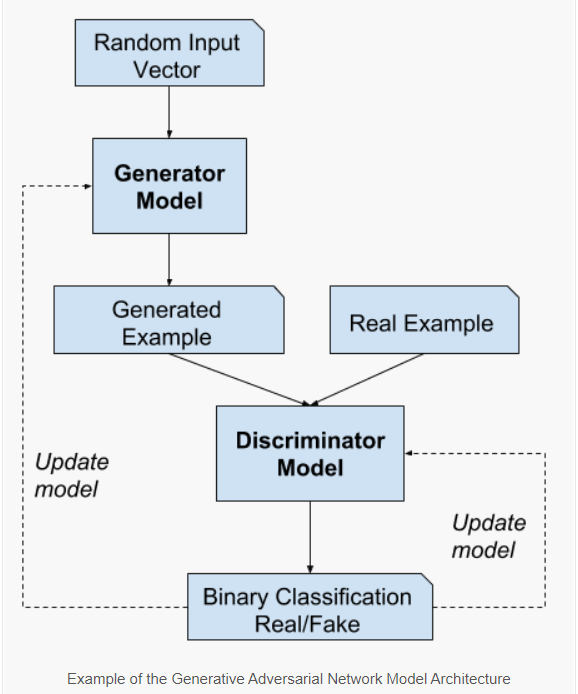

- In this notebook, two different DCGAN models have been trained. The discriminator architecture is same in both the models while the generator architecture have been changed. 
- In the first DCGAN, the generator model uses Conv2DTranspose layer to increase the spatial resolution while in the second DCGAN model, it uses UpSampling2D() layer followed by Conv2D layer. This is done to observe the difference in quality of images generated by each architecture.
- Most of the code in this notebook is taken from [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan).

## 1. Import necessary modules

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Conv2D, Dense, BatchNormalization,
                                     UpSampling2D, Conv2DTranspose, Dropout)

## 2. Load and prepare MNIST data
- This dataset contains gray images of hand-written digits from 0 - 9.
- The shape of each image is (28 x 28) pixels.

In [ ]:
# labels are not required for training GAN
(x_train, _), (x_test, _) = mnist.load_data()

print(f'Shape of x_train: {x_train.shape}\nShape of x_test: {x_test.shape}')

11493376/11490434 [==============================] - 0s 0us/step
Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)


### 2.1 Add channel dimension to the training and test data
- Tensorflow requires image data in the form of (batch_size, image_height, image_width, channel) 

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
print(f'Shape of x_train: {x_train.shape}\nShape of x_test: {x_test.shape}')

Shape of x_train: (60000, 28, 28, 1)
Shape of x_test: (10000, 28, 28, 1)


### 2.2 Concatenate x_train and x_test data

In [ ]:
train_data = tf.concat([x_train, x_test], axis = 0)
train_data.shape

TensorShape([70000, 28, 28, 1])

### 2.3 Normalize the data

In [ ]:
# train_data = train_data / 255.0
train_data = (train_data - 127.5) / 127.5

### 2.4 Set up some global variables 

In [ ]:
BUFFER_SIZE = 70000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES = 10
IMAGE_SHAPE = (28, 28, 1)

In [ ]:
## create tensorflow dataset
train_data = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3. Generator model 
- Generator model with Conv2DTranspose layers
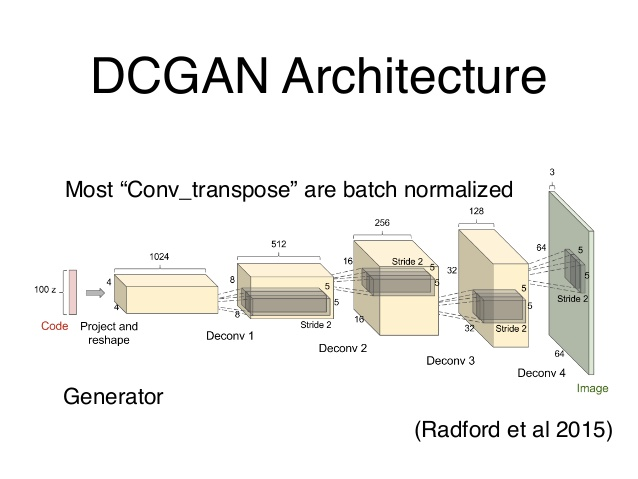

In [ ]:
def generator_model(noise_dim = NOISE_DIM):
  model = tf.keras.Sequential()
  model.add(Dense(256, use_bias = False, input_shape = (noise_dim,)))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(Dense(7 * 7 * 256, use_bias = False))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Reshape((7, 7, 256)))
  model.add(Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))

  return model

### 3.1 Summary of the generator model

In [ ]:
generator = generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               25600     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             3211264   
_________________________________________________________________
batch_normalization_4 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)        

## 4. Discriminator model
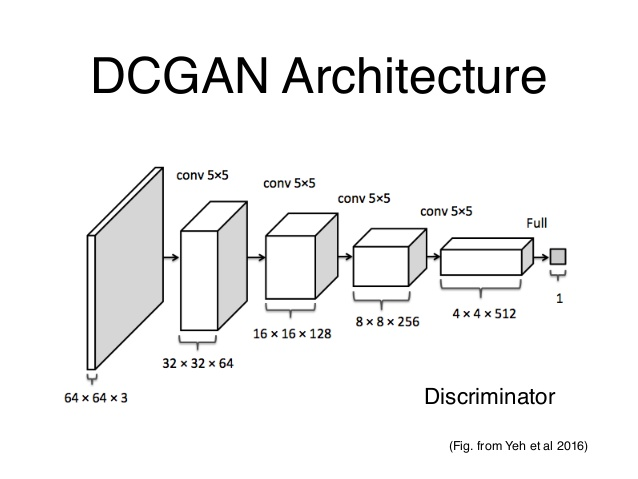

In [ ]:
def discriminator_model(shape = IMAGE_SHAPE):
  model = tf.keras.Sequential()
  model.add(Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = shape))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(tf.keras.layers.Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU(0.2))

  model.add(Dense(1))
  return model

### 4.1 Summary of the discriminator model

In [ ]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

## 5. Define binary cross entropy loss for the generator and the discriminator
- For the **discriminator network**: Compare the real logits with 1s and fake logits with 0s to calculate the loss.
- For the **generator network**: Compare the fake logits with the 1s to calculate the loss


In [ ]:
## Keras inbuilt binary cross entropy function
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def d_loss(real_output, fake_output):
  """
  This function will calculate the discriminator loss
  Args:
    real_output: logits of real images
    fake_output: logits of generated images
  """
  real_loss = bce_loss(tf.ones_like(real_output), real_output)
  fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


def g_loss(fake_output):
  """
  This function will calculate the generator loss
  Args:
    fake_output: logits of generated images
  """
  return bce_loss(tf.ones_like(fake_output), fake_output)

### 5.1 Create optimizers for generator and discriminator model

In [ ]:
g_optimizer = tf.keras.optimizers.Adam(2e-4)
d_optimizer = tf.keras.optimizers.Adam(2e-4)

## 6. Train the model

### 6.1 Define the training step

In [ ]:
@tf.function
def train_step(images, generator, discriminator):
  # sample the noise vector
  noise_vector = tf.random.normal([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    # generate fake_images
    fake_image = generator(noise_vector, training = True)

    # calculate real and fake logits
    real_output = discriminator(images, training = True)
    fake_output = discriminator(fake_image, training = True)

    # calculate generator and discriminator loss
    generator_loss = g_loss(fake_output)
    discriminator_loss = d_loss(real_output, fake_output)

  # calculate gradients of generator and discriminator 
  grads_g = g_tape.gradient(generator_loss, generator.trainable_variables)
  grads_d = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)

  # update the weights of the generator and discriminator
  g_optimizer.apply_gradients(zip(grads_g, generator.trainable_variables))
  d_optimizer.apply_gradients(zip(grads_d, discriminator.trainable_variables))

  return generator_loss, discriminator_loss

### 6.2 Model training

In [ ]:
def train(dataset, epochs, generator, discriminator):
  # iterate for the number of epochs
  for epoch in range(epochs):
    # iterate over the dataset
    for image_batch in dataset:
      loss_gen, loss_disc = train_step(image_batch, generator, discriminator)
    
    print(f'Epoch: {epoch}\t Generator loss: {loss_gen}\t Disriminator loss: {loss_disc}')

    # visualize the generated images after each epoch 
    noise_vector = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
    fake = generator(noise_vector)

    fig, axis = plt.subplots(2, 5, figsize = (14, 5))
    for i, ax in enumerate(axis.flatten()):
      ax.imshow(fake[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()
    plt.tight_layout();

    print('\n\n')

Epoch: 0	 Generator loss: 0.9162964820861816	 Disriminator loss: 1.2315046787261963


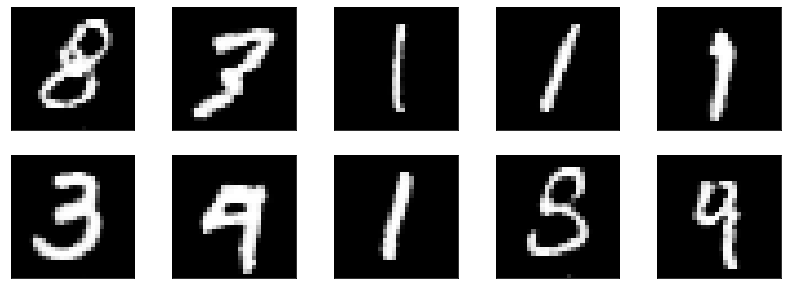

Epoch: 1	 Generator loss: 1.1184918880462646	 Disriminator loss: 1.1197638511657715


<Figure size 432x288 with 0 Axes>

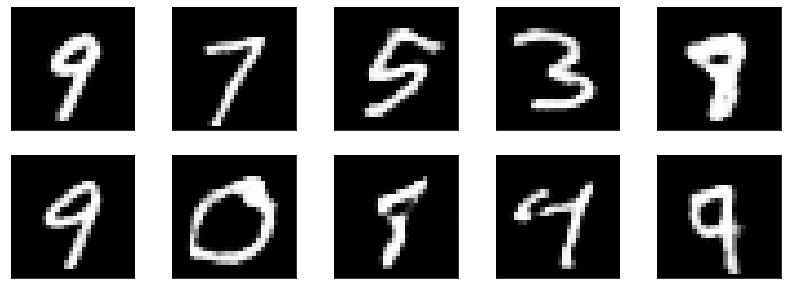

Epoch: 2	 Generator loss: 0.9101144075393677	 Disriminator loss: 1.2999951839447021


<Figure size 432x288 with 0 Axes>

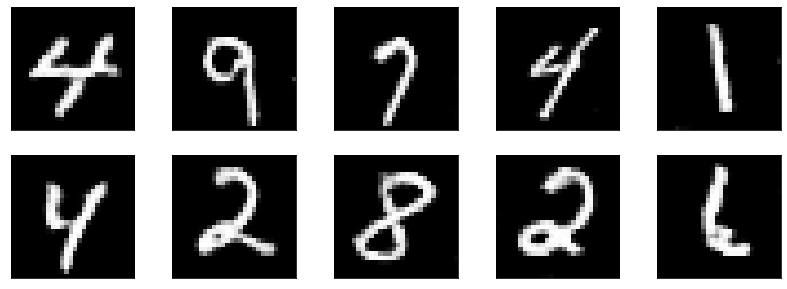

Epoch: 3	 Generator loss: 1.0839226245880127	 Disriminator loss: 1.0564014911651611


<Figure size 432x288 with 0 Axes>

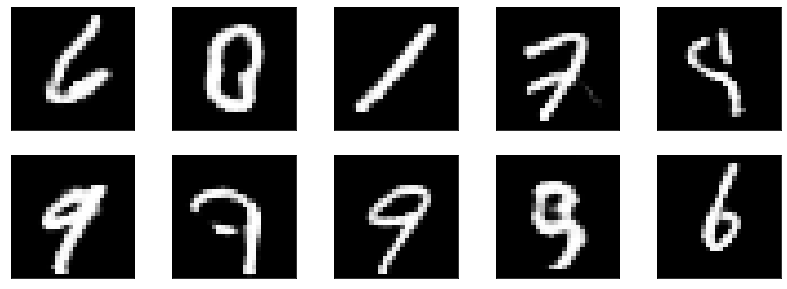

Epoch: 4	 Generator loss: 1.0055513381958008	 Disriminator loss: 1.3241862058639526


<Figure size 432x288 with 0 Axes>

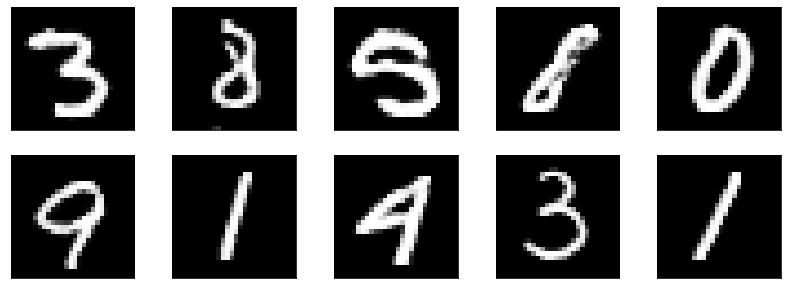

Epoch: 5	 Generator loss: 1.1593819856643677	 Disriminator loss: 1.016718864440918


<Figure size 432x288 with 0 Axes>

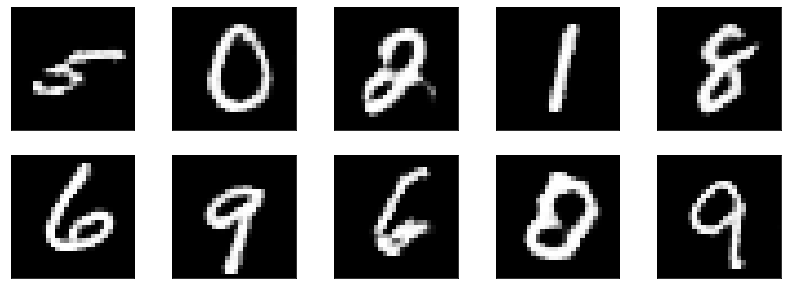

Epoch: 6	 Generator loss: 1.0591726303100586	 Disriminator loss: 1.2327842712402344


<Figure size 432x288 with 0 Axes>

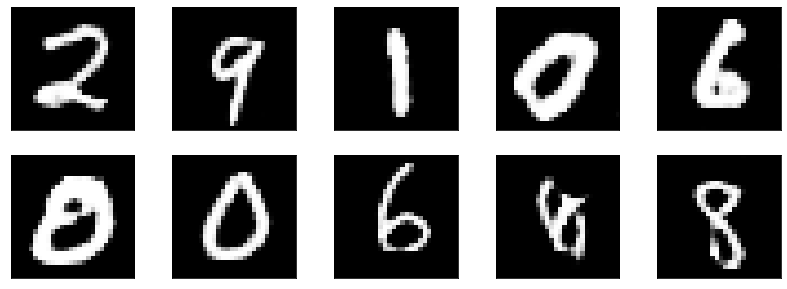

Epoch: 7	 Generator loss: 1.1085841655731201	 Disriminator loss: 1.1430097818374634


<Figure size 432x288 with 0 Axes>

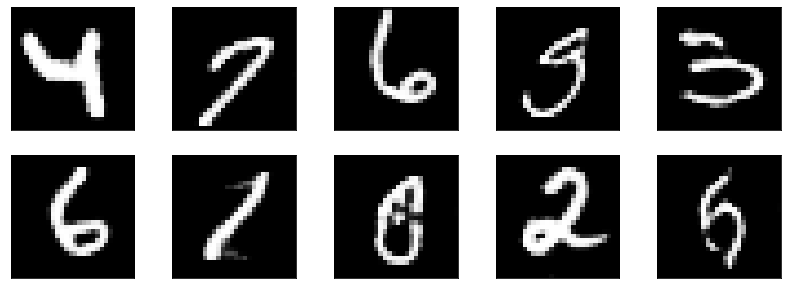

Epoch: 8	 Generator loss: 1.0632871389389038	 Disriminator loss: 1.240267276763916


<Figure size 432x288 with 0 Axes>

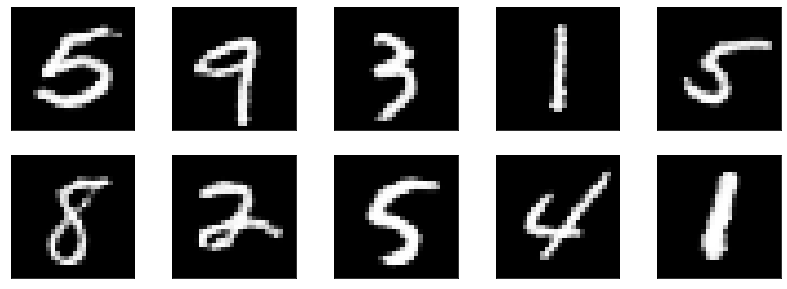

Epoch: 9	 Generator loss: 1.0364882946014404	 Disriminator loss: 1.1510076522827148


<Figure size 432x288 with 0 Axes>

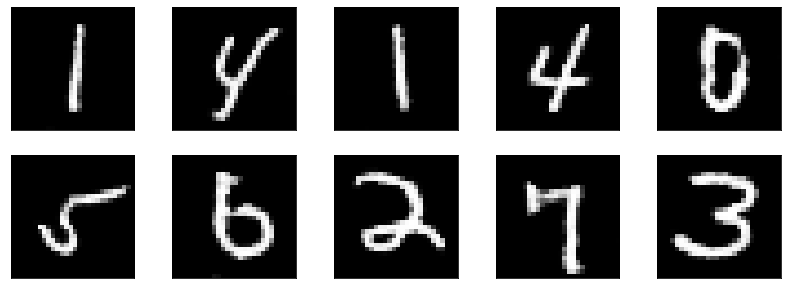

Epoch: 10	 Generator loss: 1.0796196460723877	 Disriminator loss: 1.3039146661758423


<Figure size 432x288 with 0 Axes>

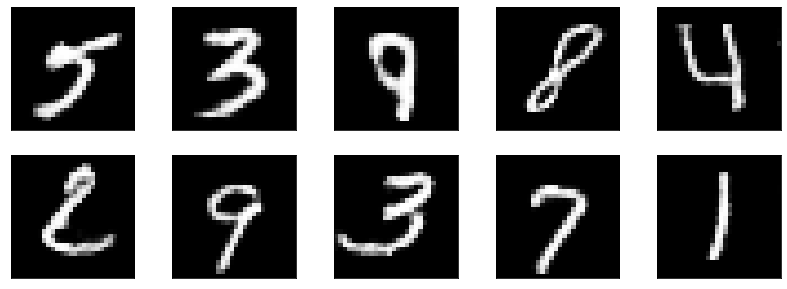

Epoch: 11	 Generator loss: 1.1046550273895264	 Disriminator loss: 1.326190710067749


<Figure size 432x288 with 0 Axes>

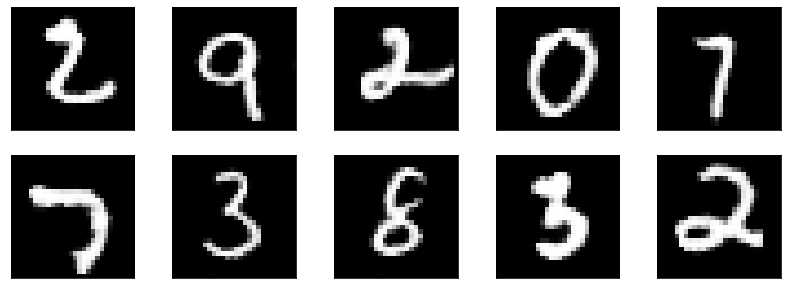

Epoch: 12	 Generator loss: 1.240907907485962	 Disriminator loss: 0.9949467182159424


<Figure size 432x288 with 0 Axes>

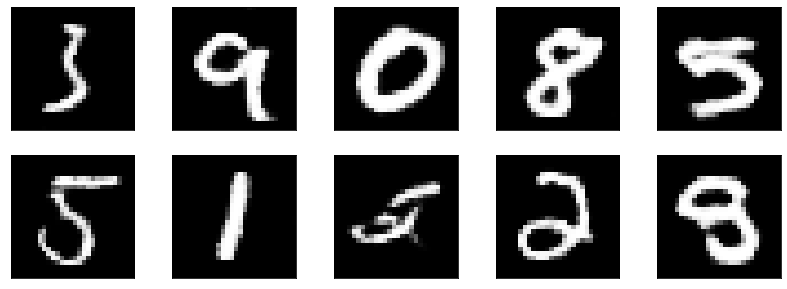

Epoch: 13	 Generator loss: 1.1909934282302856	 Disriminator loss: 1.0175013542175293


<Figure size 432x288 with 0 Axes>

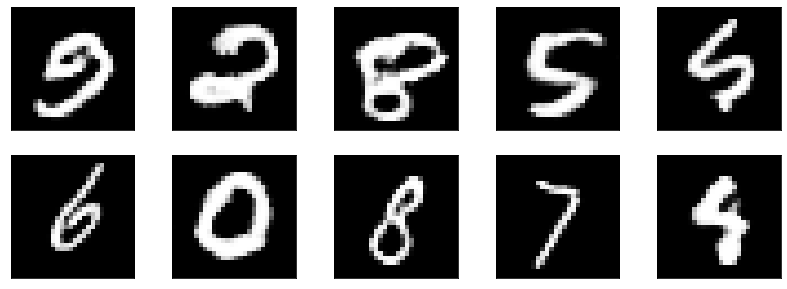

Epoch: 14	 Generator loss: 1.0955699682235718	 Disriminator loss: 1.1342229843139648


<Figure size 432x288 with 0 Axes>

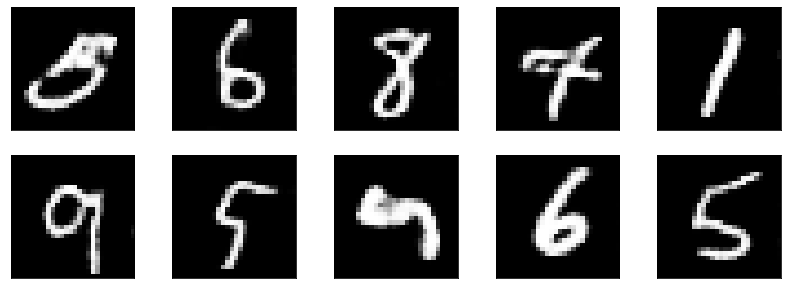

Epoch: 15	 Generator loss: 1.2241528034210205	 Disriminator loss: 1.2078118324279785


<Figure size 432x288 with 0 Axes>

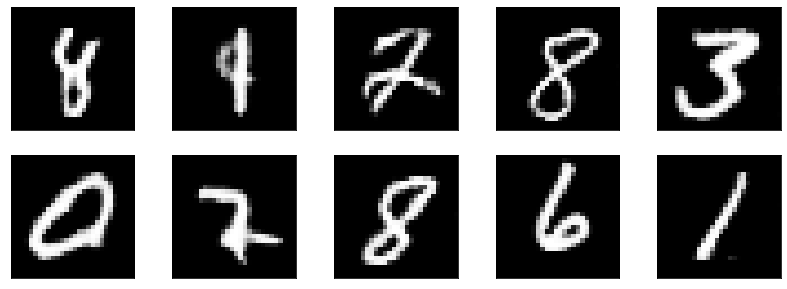

Epoch: 16	 Generator loss: 1.0301895141601562	 Disriminator loss: 1.1170923709869385


<Figure size 432x288 with 0 Axes>

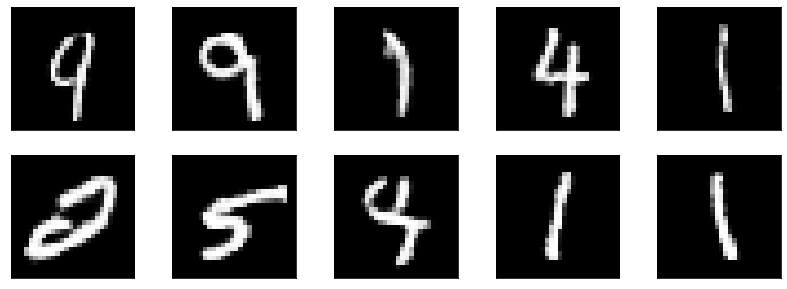

Epoch: 17	 Generator loss: 1.2572516202926636	 Disriminator loss: 1.1001472473144531


<Figure size 432x288 with 0 Axes>

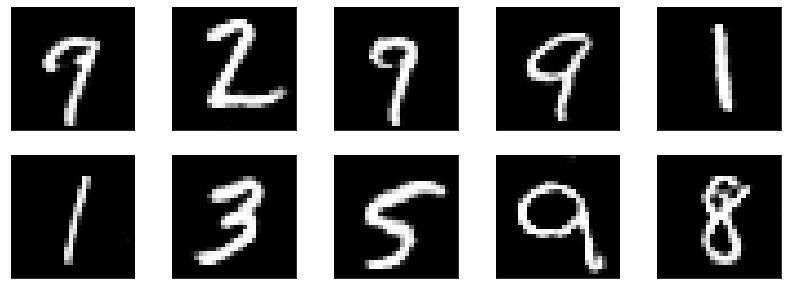

Epoch: 18	 Generator loss: 1.1419397592544556	 Disriminator loss: 1.0717504024505615


<Figure size 432x288 with 0 Axes>

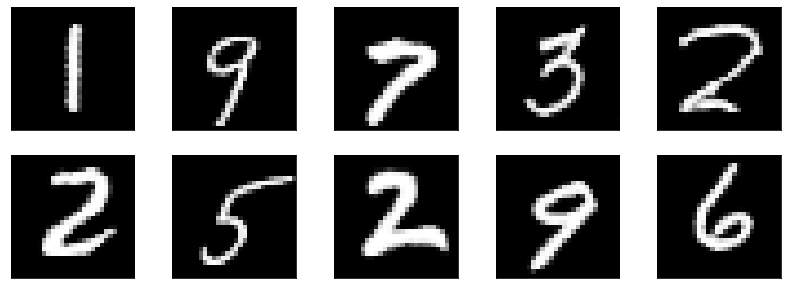

Epoch: 19	 Generator loss: 1.2033064365386963	 Disriminator loss: 1.096524953842163


<Figure size 432x288 with 0 Axes>

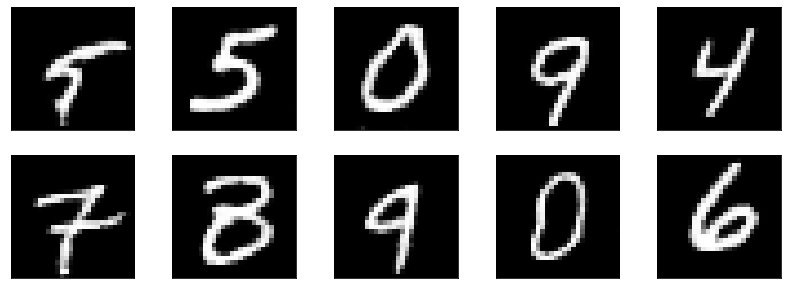

Epoch: 20	 Generator loss: 1.1905269622802734	 Disriminator loss: 1.11928391456604


<Figure size 432x288 with 0 Axes>

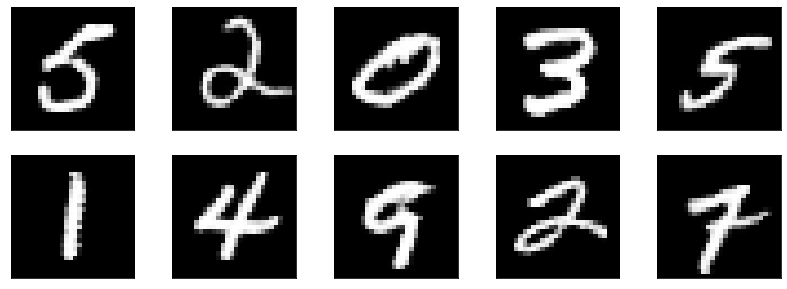

Epoch: 21	 Generator loss: 1.1712584495544434	 Disriminator loss: 1.021268367767334


<Figure size 432x288 with 0 Axes>

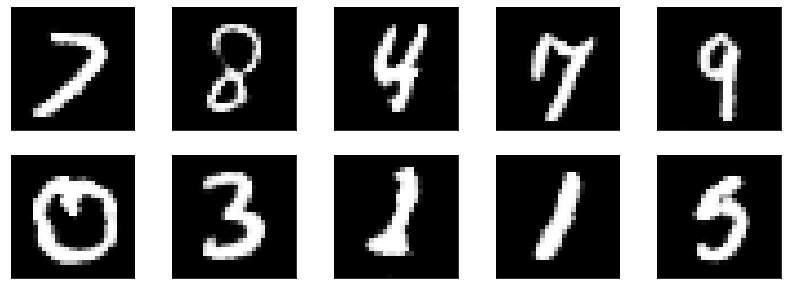

Epoch: 22	 Generator loss: 1.3185337781906128	 Disriminator loss: 1.061476469039917


<Figure size 432x288 with 0 Axes>

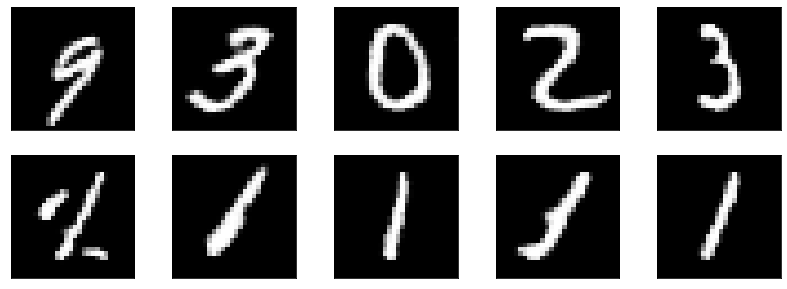

Epoch: 23	 Generator loss: 1.1975390911102295	 Disriminator loss: 1.030601978302002


<Figure size 432x288 with 0 Axes>

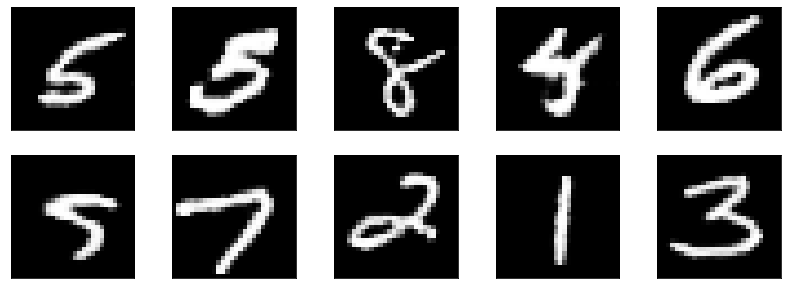

Epoch: 24	 Generator loss: 1.3551559448242188	 Disriminator loss: 0.9745620489120483


<Figure size 432x288 with 0 Axes>

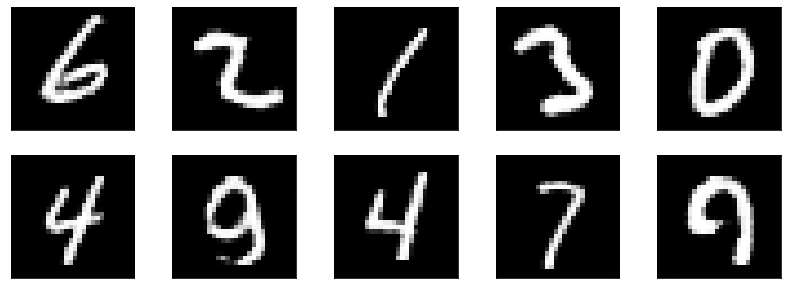

Epoch: 25	 Generator loss: 1.1119012832641602	 Disriminator loss: 1.1025502681732178


<Figure size 432x288 with 0 Axes>

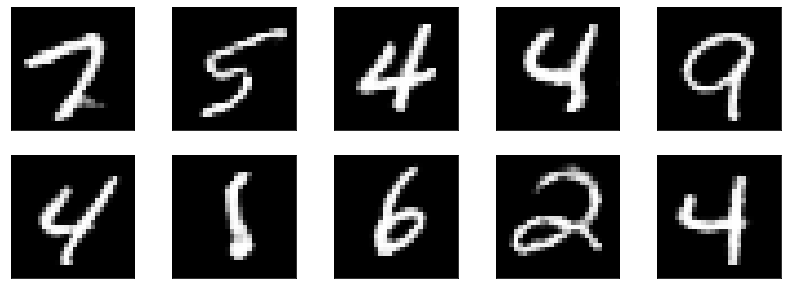

Epoch: 26	 Generator loss: 1.3009992837905884	 Disriminator loss: 1.2338242530822754


<Figure size 432x288 with 0 Axes>

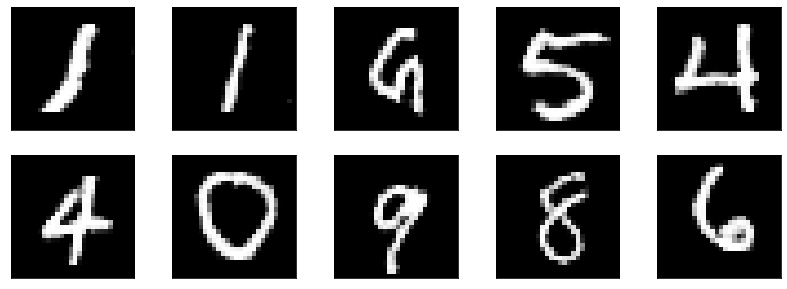

Epoch: 27	 Generator loss: 1.278030276298523	 Disriminator loss: 1.13522469997406


<Figure size 432x288 with 0 Axes>

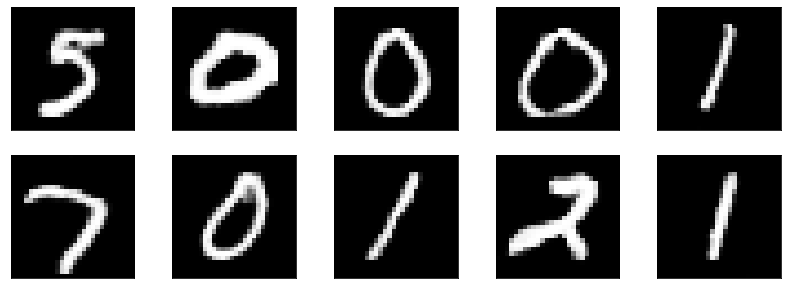

Epoch: 28	 Generator loss: 1.2465054988861084	 Disriminator loss: 0.9420626163482666


<Figure size 432x288 with 0 Axes>

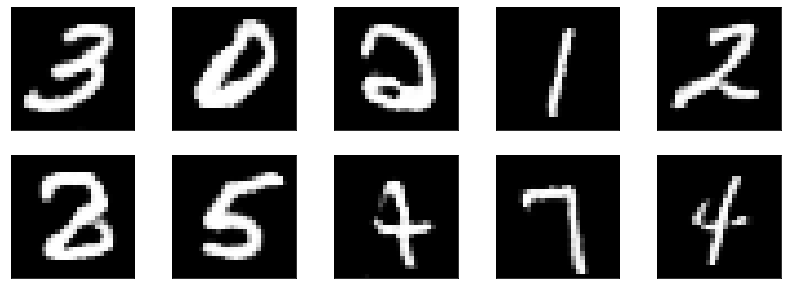

Epoch: 29	 Generator loss: 1.2600677013397217	 Disriminator loss: 1.142869234085083


<Figure size 432x288 with 0 Axes>

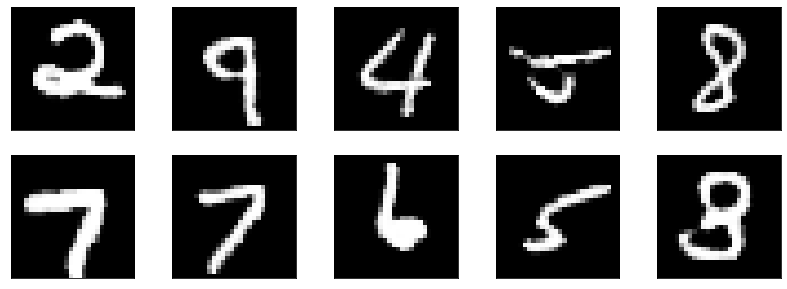

Epoch: 30	 Generator loss: 1.326094627380371	 Disriminator loss: 0.936987578868866


<Figure size 432x288 with 0 Axes>

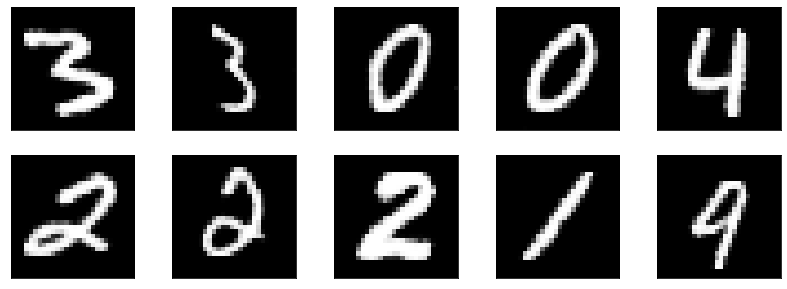

Epoch: 31	 Generator loss: 1.4595996141433716	 Disriminator loss: 1.0001269578933716


<Figure size 432x288 with 0 Axes>

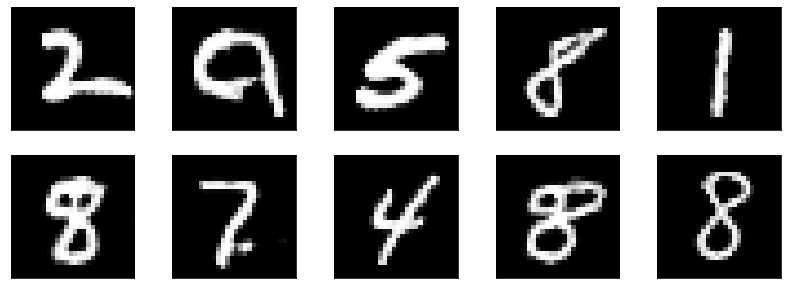

Epoch: 32	 Generator loss: 1.3090893030166626	 Disriminator loss: 1.2663426399230957


<Figure size 432x288 with 0 Axes>

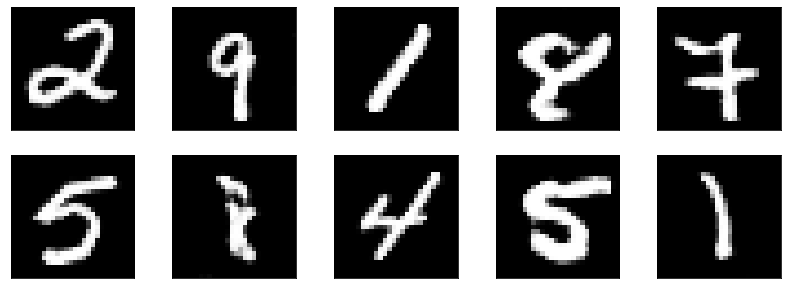

Epoch: 33	 Generator loss: 1.1981686353683472	 Disriminator loss: 1.2396299839019775


<Figure size 432x288 with 0 Axes>

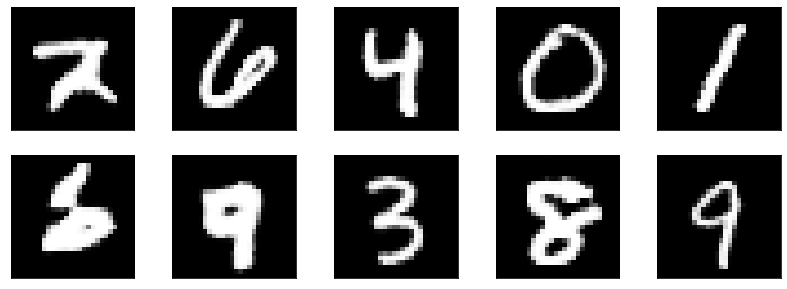

Epoch: 34	 Generator loss: 1.3747316598892212	 Disriminator loss: 0.906792163848877


<Figure size 432x288 with 0 Axes>

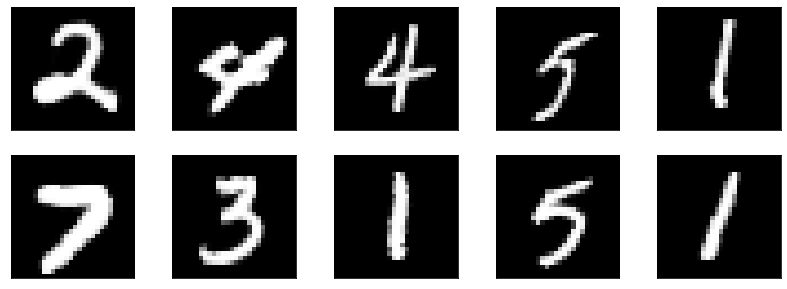

Epoch: 35	 Generator loss: 1.3611385822296143	 Disriminator loss: 1.0591394901275635


<Figure size 432x288 with 0 Axes>

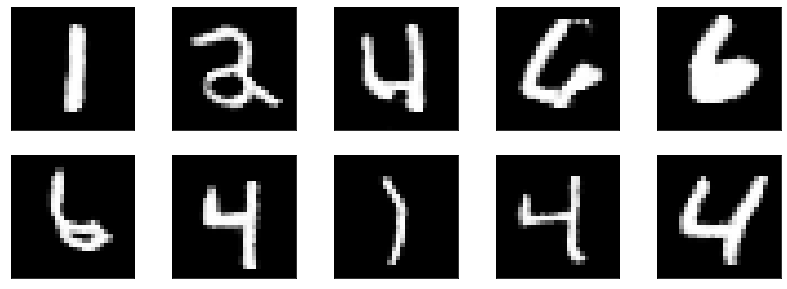

Epoch: 36	 Generator loss: 1.1441272497177124	 Disriminator loss: 1.0924019813537598


<Figure size 432x288 with 0 Axes>

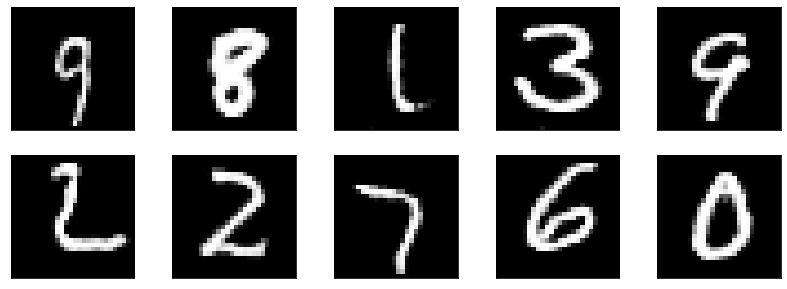

Epoch: 37	 Generator loss: 1.4538789987564087	 Disriminator loss: 0.8666760921478271


<Figure size 432x288 with 0 Axes>

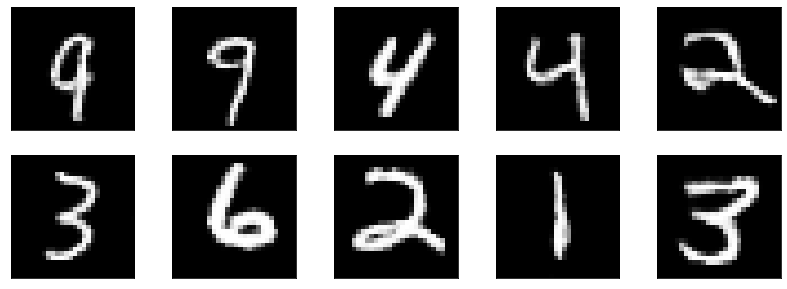

Epoch: 38	 Generator loss: 1.4877758026123047	 Disriminator loss: 0.8844608068466187


<Figure size 432x288 with 0 Axes>

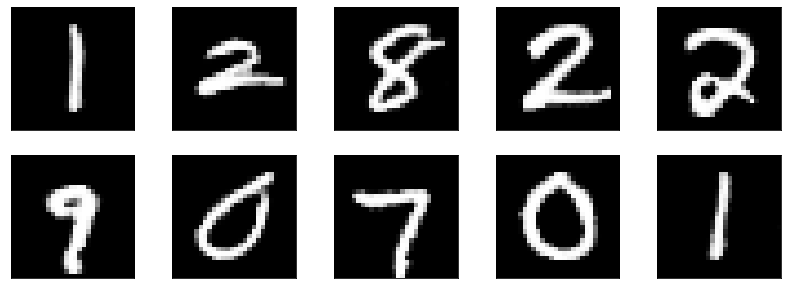

Epoch: 39	 Generator loss: 1.2632616758346558	 Disriminator loss: 1.0656630992889404


<Figure size 432x288 with 0 Axes>

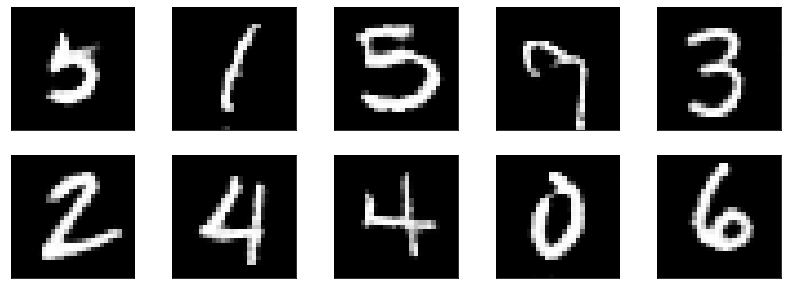

Epoch: 40	 Generator loss: 1.311405897140503	 Disriminator loss: 1.028517484664917


<Figure size 432x288 with 0 Axes>

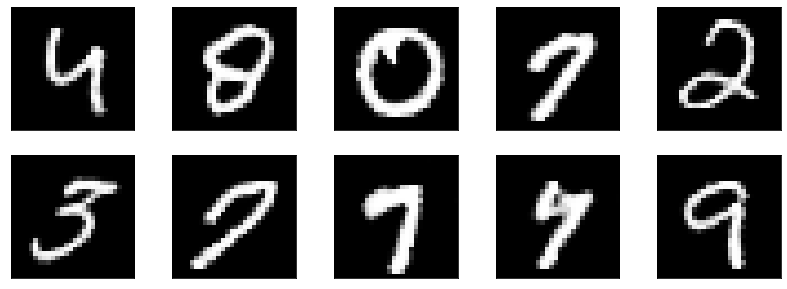

Epoch: 41	 Generator loss: 1.3690690994262695	 Disriminator loss: 0.9947882294654846


<Figure size 432x288 with 0 Axes>

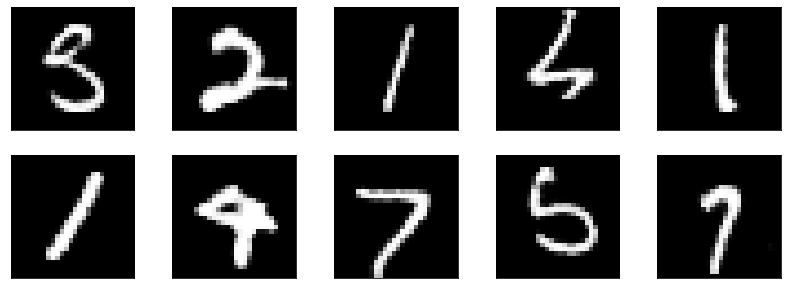

Epoch: 42	 Generator loss: 1.3783471584320068	 Disriminator loss: 0.8200998902320862


<Figure size 432x288 with 0 Axes>

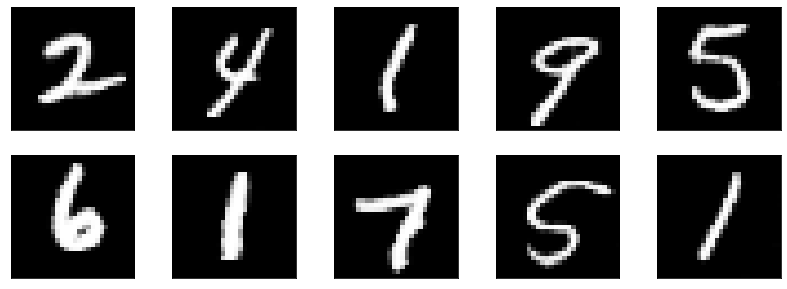

Epoch: 43	 Generator loss: 1.5933544635772705	 Disriminator loss: 0.9511851668357849


<Figure size 432x288 with 0 Axes>

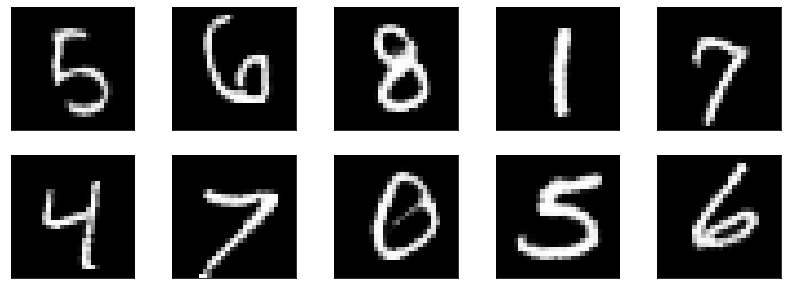

Epoch: 44	 Generator loss: 1.1607754230499268	 Disriminator loss: 1.0193736553192139


<Figure size 432x288 with 0 Axes>

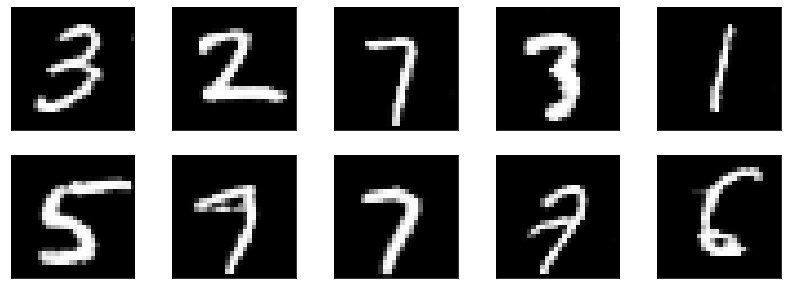

Epoch: 45	 Generator loss: 1.338488221168518	 Disriminator loss: 1.292184591293335


<Figure size 432x288 with 0 Axes>

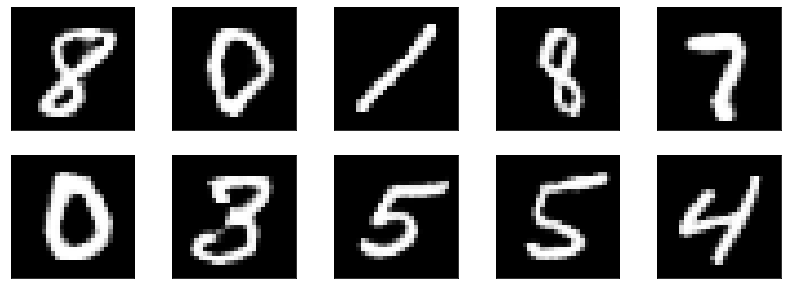

Epoch: 46	 Generator loss: 1.5885406732559204	 Disriminator loss: 0.9647967219352722


<Figure size 432x288 with 0 Axes>

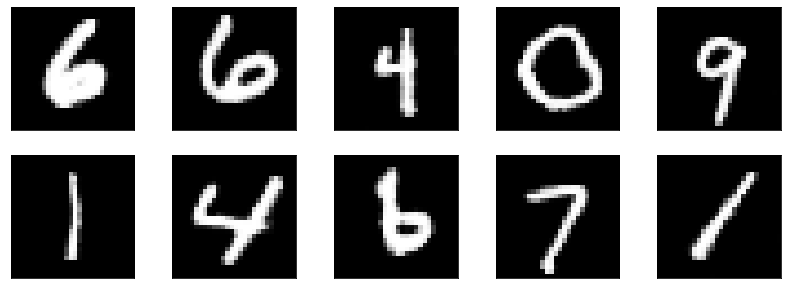

Epoch: 47	 Generator loss: 1.5018833875656128	 Disriminator loss: 1.1986162662506104


<Figure size 432x288 with 0 Axes>

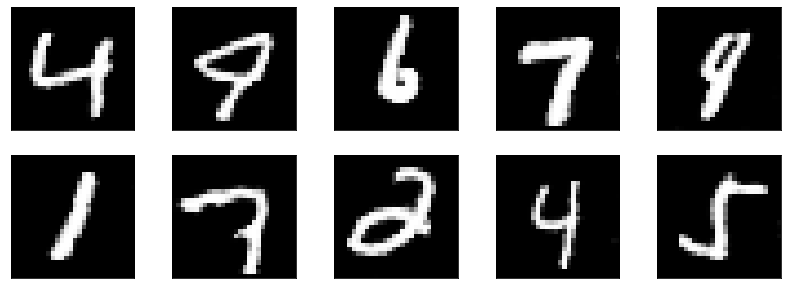

Epoch: 48	 Generator loss: 1.3454042673110962	 Disriminator loss: 0.9018270373344421


<Figure size 432x288 with 0 Axes>

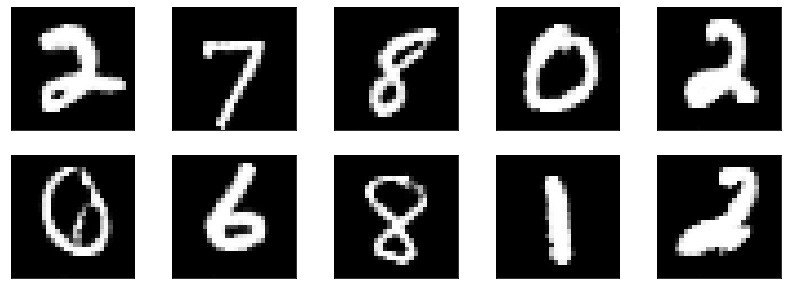

Epoch: 49	 Generator loss: 1.3816245794296265	 Disriminator loss: 0.8743817806243896


<Figure size 432x288 with 0 Axes>

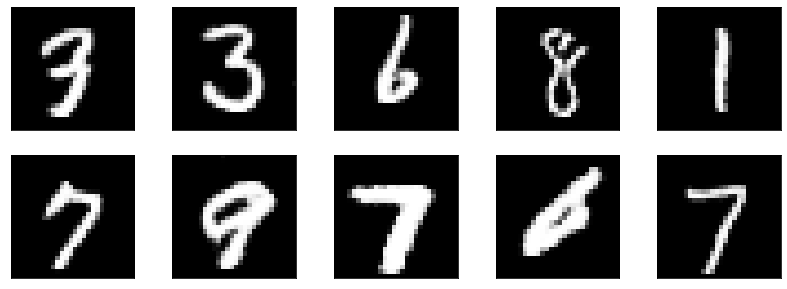

<Figure size 432x288 with 0 Axes>

In [ ]:
# train the models and display the generated images
train(train_data, EPOCHS, generator, discriminator)

## 7. Generator model with UpSampling2D layers

In [ ]:
def build_generator():
  model = tf.keras.Sequential()
  model.add(Dense(256, input_shape = (100, )))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(tf.keras.layers.Activation('relu'))

  model.add(Dense(7 * 7 * 256))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Reshape((7, 7, 256)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size = 3, padding = "same"))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(tf.keras.layers.Activation('relu'))

  model.add(UpSampling2D())
  model.add(Conv2D(64, kernel_size = 3, padding = "same"))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(tf.keras.layers.Activation('relu'))

  model.add(Conv2D(1, kernel_size = 3, padding = "same"))
  model.add(tf.keras.layers.Activation('tanh'))

  return model

In [ ]:
# summary of the generator model
new_gen = build_generator()
new_gen.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               25856     
_________________________________________________________________
batch_normalization_24 (Batc (None, 256)               1024      
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 12544)             3223808   
_________________________________________________________________
batch_normalization_25 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_18 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)        

In [ ]:
# build discriminator model
new_disc = disc_model()
output = new_disc(gen_image)
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0007119]], dtype=float32)>

Epoch: 0	 Generator loss: 0.8256884813308716	 Disriminator loss: 1.177132487297058


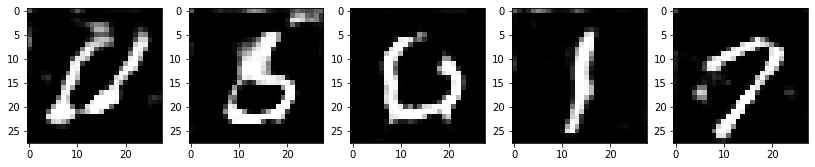

Epoch: 1	 Generator loss: 0.8314202427864075	 Disriminator loss: 1.2729909420013428


<Figure size 432x288 with 0 Axes>

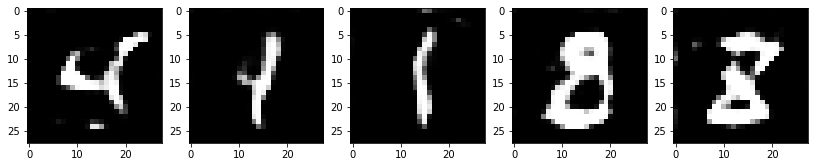

Epoch: 2	 Generator loss: 0.8178717494010925	 Disriminator loss: 1.261282205581665


<Figure size 432x288 with 0 Axes>

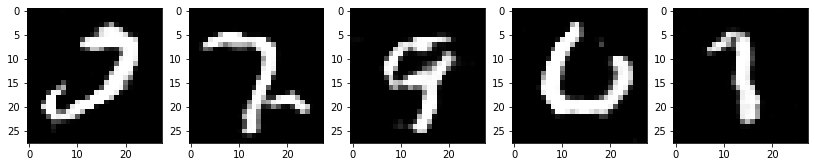

Epoch: 3	 Generator loss: 0.8656433820724487	 Disriminator loss: 1.219648838043213


<Figure size 432x288 with 0 Axes>

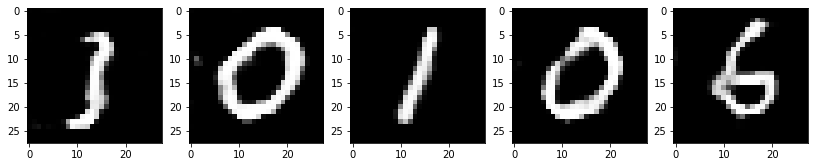

Epoch: 4	 Generator loss: 0.7151380777359009	 Disriminator loss: 1.4375245571136475


<Figure size 432x288 with 0 Axes>

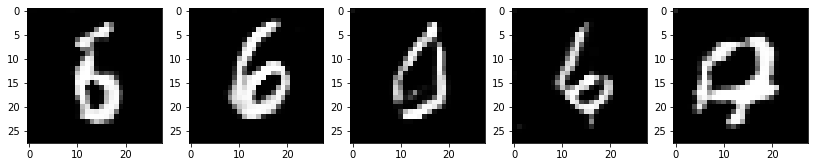

Epoch: 5	 Generator loss: 0.9009102582931519	 Disriminator loss: 1.2850358486175537


<Figure size 432x288 with 0 Axes>

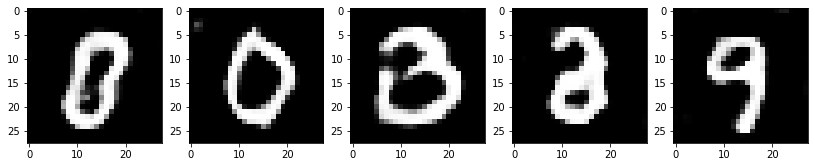

Epoch: 6	 Generator loss: 0.7160429358482361	 Disriminator loss: 1.3835945129394531


<Figure size 432x288 with 0 Axes>

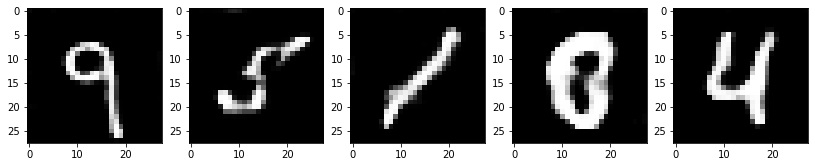

Epoch: 7	 Generator loss: 0.6950445175170898	 Disriminator loss: 1.365378975868225


<Figure size 432x288 with 0 Axes>

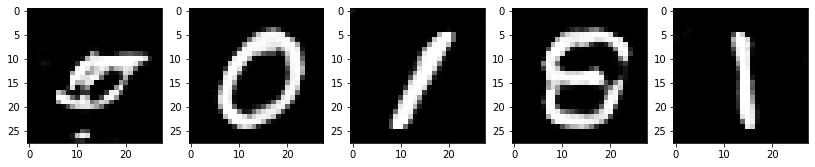

Epoch: 8	 Generator loss: 0.7013741135597229	 Disriminator loss: 1.3618180751800537


<Figure size 432x288 with 0 Axes>

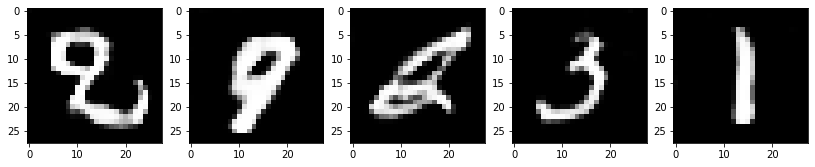

Epoch: 9	 Generator loss: 0.8405159711837769	 Disriminator loss: 1.2327067852020264


<Figure size 432x288 with 0 Axes>

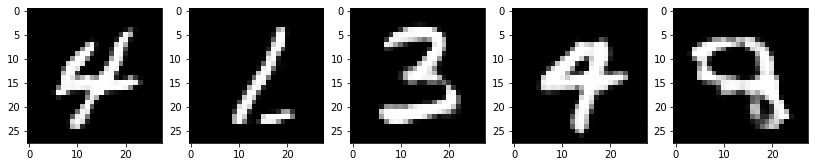

Epoch: 10	 Generator loss: 0.835843563079834	 Disriminator loss: 1.2819430828094482


<Figure size 432x288 with 0 Axes>

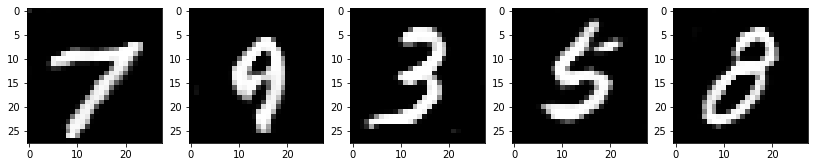

Epoch: 11	 Generator loss: 0.8270571231842041	 Disriminator loss: 1.2950477600097656


<Figure size 432x288 with 0 Axes>

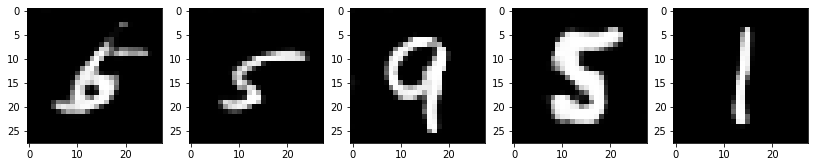

Epoch: 12	 Generator loss: 0.8264391422271729	 Disriminator loss: 1.2420191764831543


<Figure size 432x288 with 0 Axes>

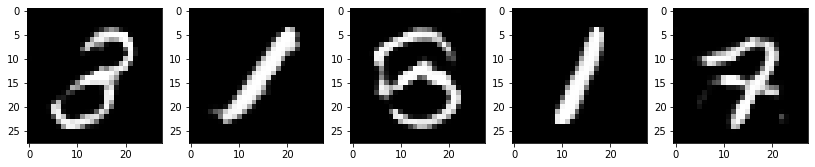

Epoch: 13	 Generator loss: 0.8310490250587463	 Disriminator loss: 1.2554898262023926


<Figure size 432x288 with 0 Axes>

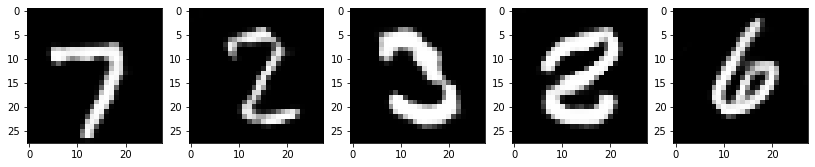

Epoch: 14	 Generator loss: 0.8031637072563171	 Disriminator loss: 1.3011319637298584


<Figure size 432x288 with 0 Axes>

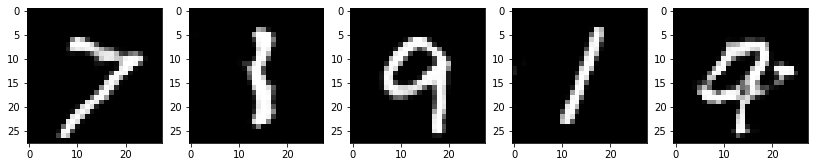

Epoch: 15	 Generator loss: 0.9049999117851257	 Disriminator loss: 1.2870439291000366


<Figure size 432x288 with 0 Axes>

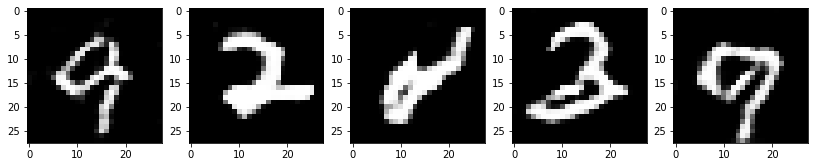

Epoch: 16	 Generator loss: 0.7723509669303894	 Disriminator loss: 1.322129249572754


<Figure size 432x288 with 0 Axes>

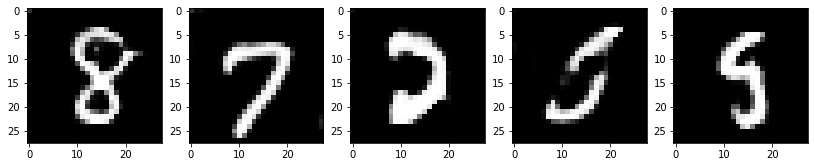

Epoch: 17	 Generator loss: 0.90472412109375	 Disriminator loss: 1.2466545104980469


<Figure size 432x288 with 0 Axes>

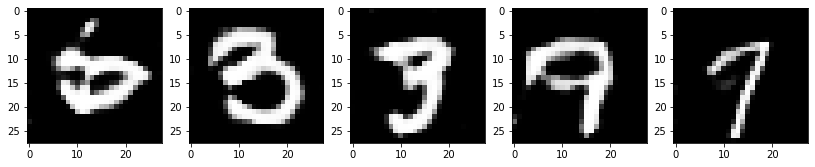

Epoch: 18	 Generator loss: 0.7952669858932495	 Disriminator loss: 1.3033316135406494


<Figure size 432x288 with 0 Axes>

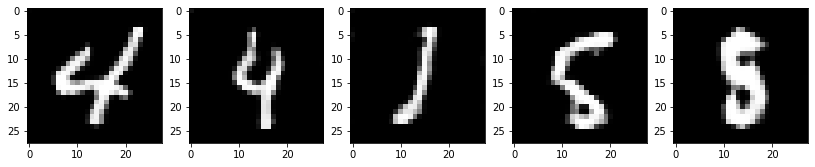

Epoch: 19	 Generator loss: 0.9107066988945007	 Disriminator loss: 1.275697112083435


<Figure size 432x288 with 0 Axes>

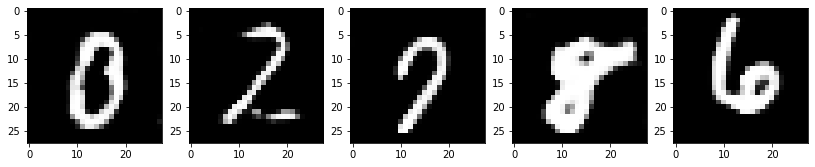

Epoch: 20	 Generator loss: 0.8757619261741638	 Disriminator loss: 1.28727126121521


<Figure size 432x288 with 0 Axes>

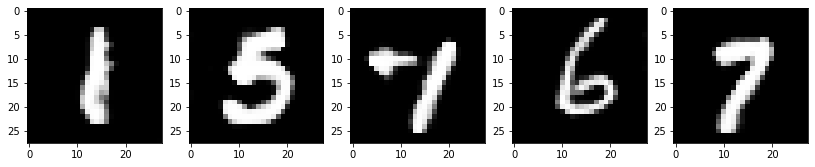

Epoch: 21	 Generator loss: 0.7796031832695007	 Disriminator loss: 1.343294382095337


<Figure size 432x288 with 0 Axes>

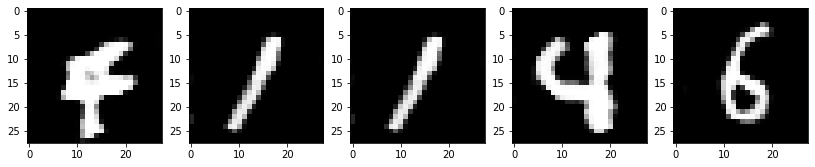

Epoch: 22	 Generator loss: 0.8043444156646729	 Disriminator loss: 1.27888822555542


<Figure size 432x288 with 0 Axes>

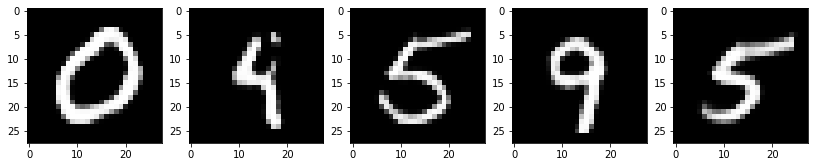

Epoch: 23	 Generator loss: 0.7777714729309082	 Disriminator loss: 1.3250572681427002


<Figure size 432x288 with 0 Axes>

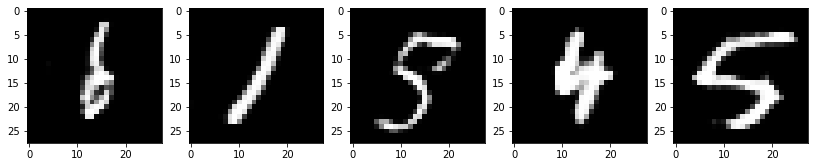

Epoch: 24	 Generator loss: 0.7863319516181946	 Disriminator loss: 1.2846053838729858


<Figure size 432x288 with 0 Axes>

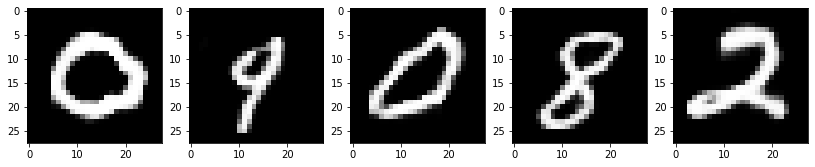

Epoch: 25	 Generator loss: 0.8380439877510071	 Disriminator loss: 1.3578381538391113


<Figure size 432x288 with 0 Axes>

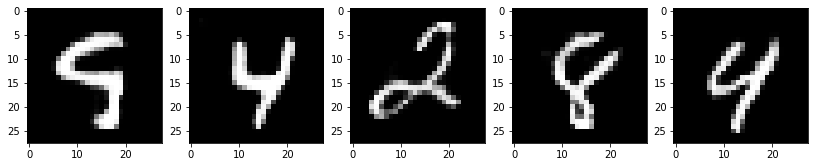

Epoch: 26	 Generator loss: 0.8773243427276611	 Disriminator loss: 1.2858872413635254


<Figure size 432x288 with 0 Axes>

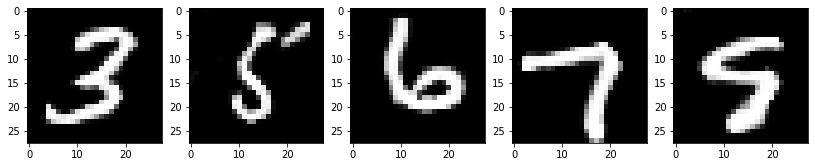

Epoch: 27	 Generator loss: 0.9610210061073303	 Disriminator loss: 1.1456000804901123


<Figure size 432x288 with 0 Axes>

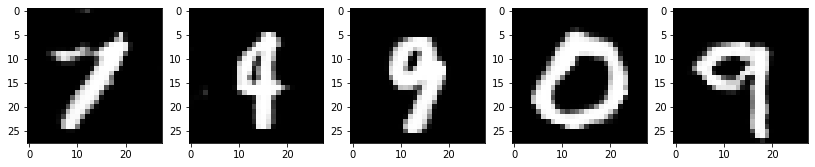

Epoch: 28	 Generator loss: 0.8770182132720947	 Disriminator loss: 1.166448712348938


<Figure size 432x288 with 0 Axes>

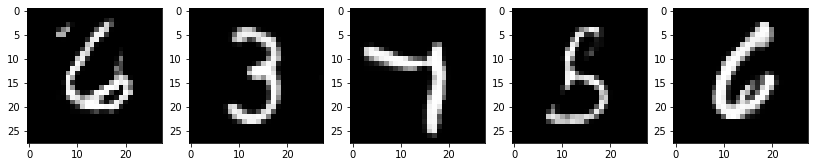

Epoch: 29	 Generator loss: 0.8810136914253235	 Disriminator loss: 1.2447404861450195


<Figure size 432x288 with 0 Axes>

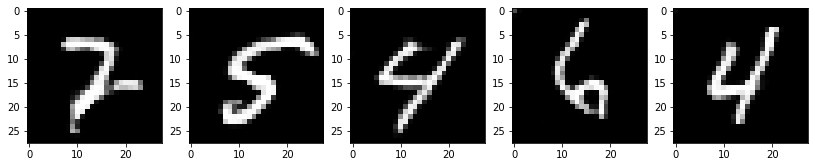

Epoch: 30	 Generator loss: 0.8226665258407593	 Disriminator loss: 1.273046851158142


<Figure size 432x288 with 0 Axes>

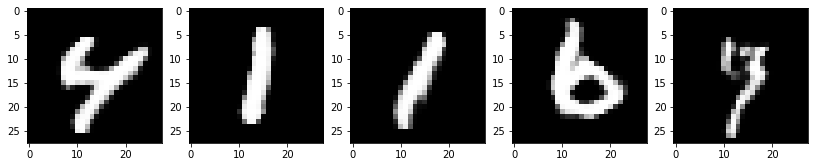

Epoch: 31	 Generator loss: 0.8123745918273926	 Disriminator loss: 1.2733566761016846


<Figure size 432x288 with 0 Axes>

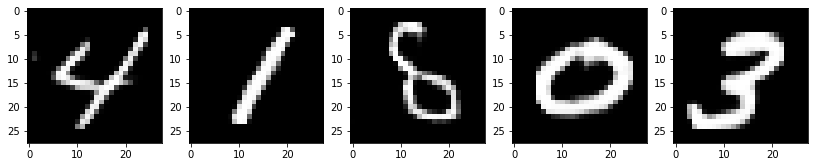

Epoch: 32	 Generator loss: 0.7840912938117981	 Disriminator loss: 1.2639148235321045


<Figure size 432x288 with 0 Axes>

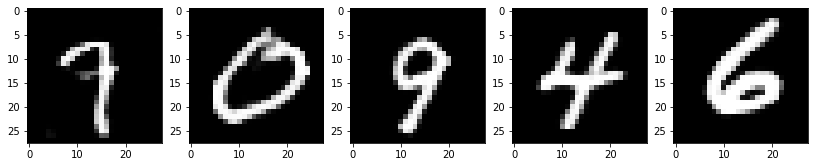

Epoch: 33	 Generator loss: 0.8203073143959045	 Disriminator loss: 1.2771883010864258


<Figure size 432x288 with 0 Axes>

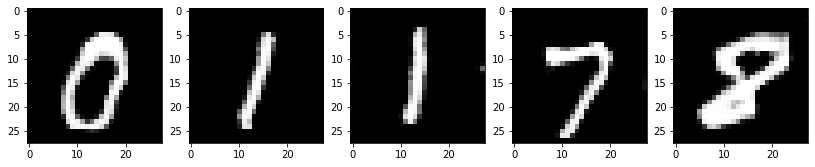

Epoch: 34	 Generator loss: 0.8195329308509827	 Disriminator loss: 1.3623533248901367


<Figure size 432x288 with 0 Axes>

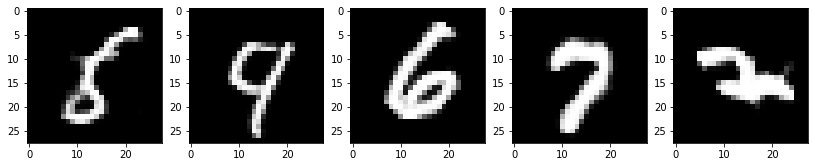

Epoch: 35	 Generator loss: 0.797209620475769	 Disriminator loss: 1.3192657232284546


<Figure size 432x288 with 0 Axes>

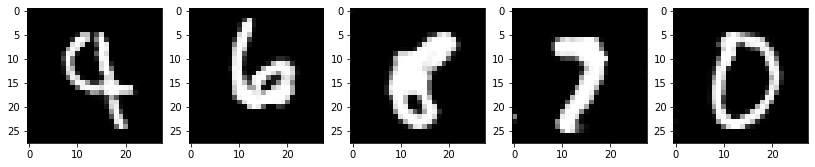

Epoch: 36	 Generator loss: 0.7952357530593872	 Disriminator loss: 1.2730560302734375


<Figure size 432x288 with 0 Axes>

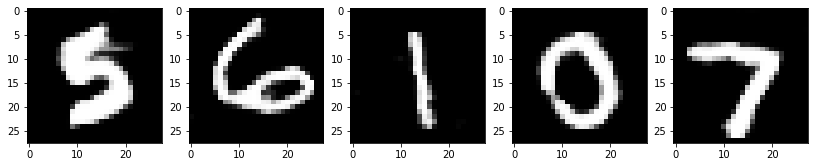

Epoch: 37	 Generator loss: 0.836421549320221	 Disriminator loss: 1.246850609779358


<Figure size 432x288 with 0 Axes>

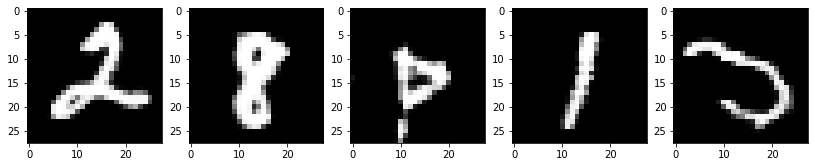

Epoch: 38	 Generator loss: 0.8074301481246948	 Disriminator loss: 1.3482418060302734


<Figure size 432x288 with 0 Axes>

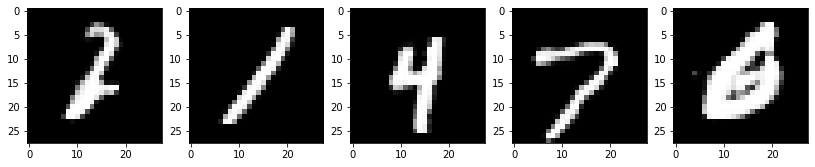

Epoch: 39	 Generator loss: 0.8929398655891418	 Disriminator loss: 1.2375050783157349


<Figure size 432x288 with 0 Axes>

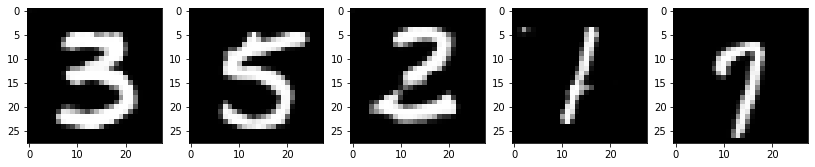

Epoch: 40	 Generator loss: 1.029843807220459	 Disriminator loss: 1.1479668617248535


<Figure size 432x288 with 0 Axes>

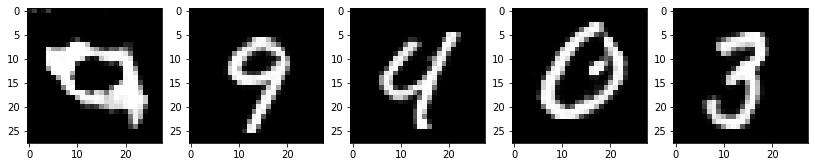

Epoch: 41	 Generator loss: 0.8620796203613281	 Disriminator loss: 1.1665188074111938


<Figure size 432x288 with 0 Axes>

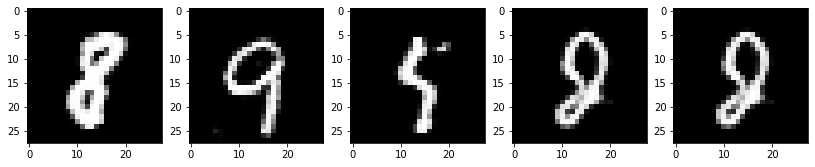

Epoch: 42	 Generator loss: 0.8543257117271423	 Disriminator loss: 1.2675597667694092


<Figure size 432x288 with 0 Axes>

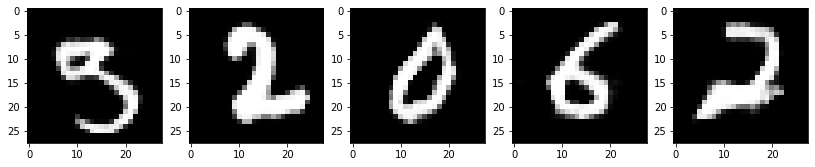

Epoch: 43	 Generator loss: 0.9298827052116394	 Disriminator loss: 1.210547685623169


<Figure size 432x288 with 0 Axes>

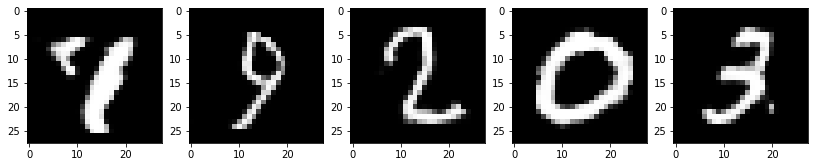

Epoch: 44	 Generator loss: 0.9939537048339844	 Disriminator loss: 1.2385932207107544


<Figure size 432x288 with 0 Axes>

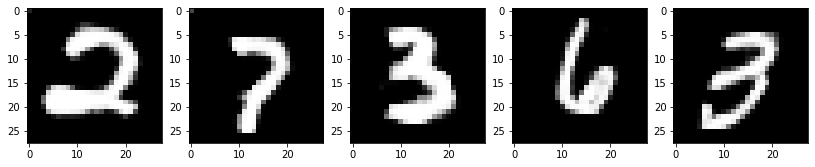

Epoch: 45	 Generator loss: 0.8131457567214966	 Disriminator loss: 1.3037827014923096


<Figure size 432x288 with 0 Axes>

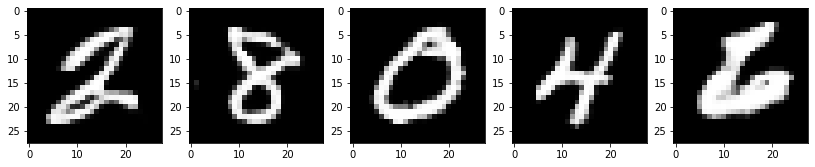

Epoch: 46	 Generator loss: 0.8950228691101074	 Disriminator loss: 1.2371330261230469


<Figure size 432x288 with 0 Axes>

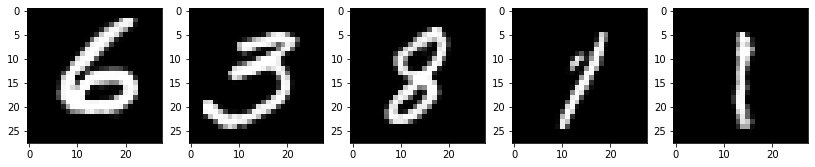

Epoch: 47	 Generator loss: 0.970458984375	 Disriminator loss: 1.2064192295074463


<Figure size 432x288 with 0 Axes>

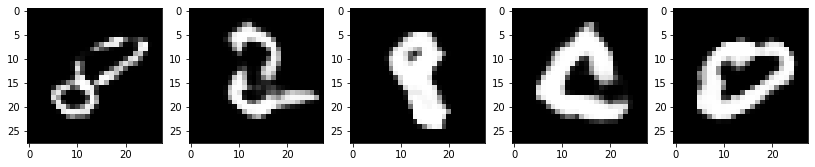

Epoch: 48	 Generator loss: 0.9346964955329895	 Disriminator loss: 1.239689588546753


<Figure size 432x288 with 0 Axes>

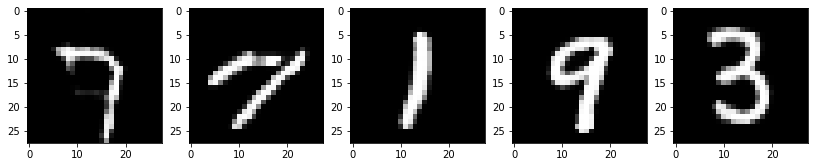

Epoch: 49	 Generator loss: 0.9373396635055542	 Disriminator loss: 1.3273744583129883


<Figure size 432x288 with 0 Axes>

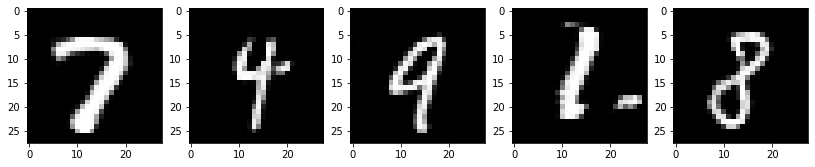

<Figure size 432x288 with 0 Axes>

In [ ]:
# train the models and display the generated images
train(train_data, EPOCHS, new_gen, new_disc)

## 8. Conclusion
- The DCGAN model that uses Conv2DTranspose layer in the generator architecture to increase the spatial resolution, has generated better quality images as compared to the generator architecture that uses UpSampling2D layer followed by Conv2D layer. 
- This difference can be seen from the images generated above.